# Functions: data loading, concat + filter/trim the data, calculate results

In [73]:
import functions as f
import importlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
importlib.reload(f)
indices = ['sp500', 'ftse100', 'nikkei225']
data_dir = r"C:\\physics_masters\\data\\"


# SP500 results

In [74]:
dataframes = f.load_data_foreign('sp500', data_dir)


In [75]:
importlib.reload(f)
df_concat = f.concat_and_select(dataframes, 0.99, cpi_file="CPI_US.csv")
df_concat, index_series = f.calculate_returns(df_concat)

% of stocks remaining: 85.29%
% of dates remaining: 100.00%
Number of stocks: 429
Number of dates: 3645
% of nans: 0.03%


<Axes: xlabel='Date'>

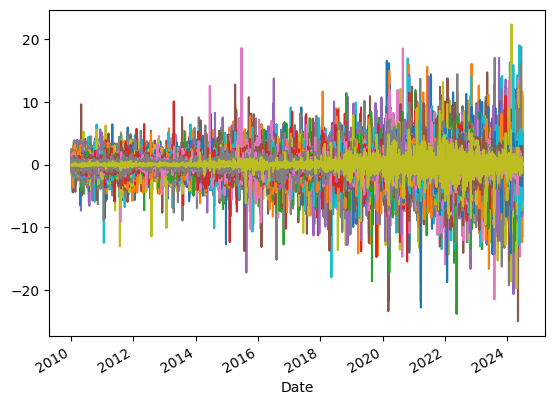

In [76]:
df_concat.plot(legend=False)

<I^2> = 0.3221
rho_0*sigma2_0 = 0.1930


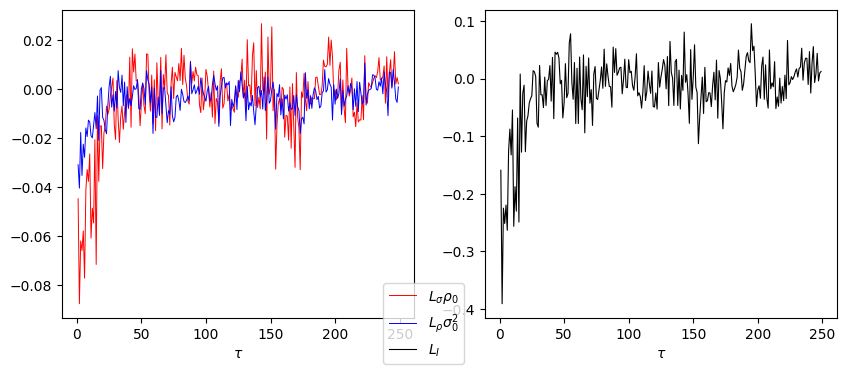

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
data = f.calculate_correlation_functions(df_concat, df_concat.mean(axis=1))

f.plot_correlation_functions(data, fig, ax)


# SP500 and FTSE100

In [78]:
indices = ['sp500', 'ftse100']


dataframes = []
for index in indices:
    dataframes += f.load_data_foreign(index, data_dir)
df_concat = f.concat_and_select(dataframes, 0.9)
df_concat, index_series = f.calculate_returns(df_concat)



% of stocks remaining: 86.07%
% of dates remaining: 97.83%
Number of stocks: 519
Number of dates: 3645
% of nans: 0.66%


<I^2> = 0.2753
rho_0*sigma2_0 = 0.1635


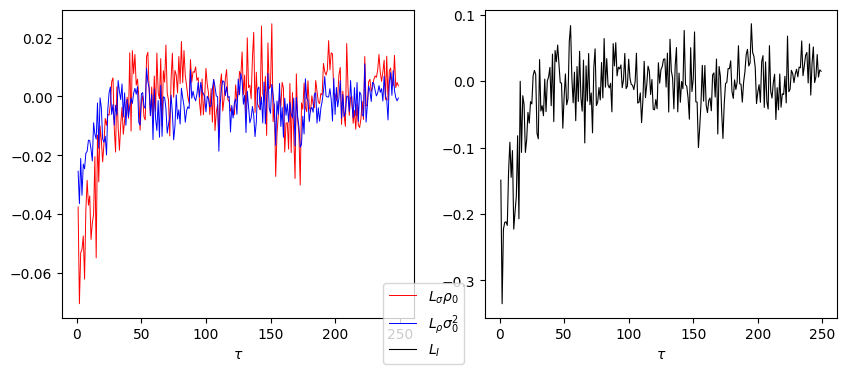

In [79]:
importlib.reload(f)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

data = f.calculate_correlation_functions(df_concat, index_series)

f.plot_correlation_functions(data, fig, ax)


# SP500 old

% of stocks remaining: 94.52%
% of dates remaining: 100.00%
Number of stocks: 397
Number of dates: 1258
% of nans: 0.10%
<I^2> = 0.3952
rho_0*sigma2_0 = 0.2377


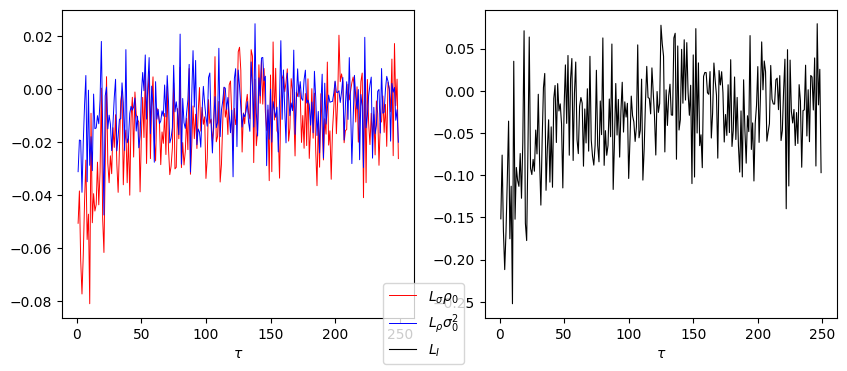

In [25]:
importlib.reload(f)
dataframes = f.load_data_foreign('sp500_old', data_dir)
df_concat = f.concat_dfs_by_date(dataframes, 0.90, '2006', '2010', smooth_local_volatility=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

data = f.calculate_correlation_functions(df_concat, df_concat.mean(axis=1))

f.plot_correlation_functions(data, fig, ax)

